In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from syspy.skims import skims
from quetzal.io import excel

# Modelling step assignment
## Needs LoS tables and logit probabilities
## Saves loaded network

In [3]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Create a path for output files and plots
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [6]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [7]:
# Load road links either from network path or from the
# equilibrium assignment path
if scenario.endswith('equilibrium'):
    road = stepmodel.read_json(model_path + 'de_road_network')
else:
    road = stepmodel.read_json(network_path + 'de_road_network')
sm.road_links = road.road_links

In [8]:
sm.segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
purposes = [s.split('_')[0] for s in sm.segments][::2]

In [9]:
# Load volumes
volumes_file = 'de_volumes'
v = stepmodel.read_zippedpickles(model_path + volumes_file)
# Rename columns from VP2030 to match the model's demand segments
car_segment_dict = {'0': '_no_car', '1': '_car'}
vp_purpose_dict = {'Fz1': 'commuting', 'Fz2': 'education', 'Fz3': 'buy/execute',
                   'Fz4': 'business', 'Fz6': 'leisure'}
sm.volumes = v.volumes.rename(columns={
    c: vp_purpose_dict[c.split('_')[0]]+car_segment_dict[c.split('_')[-1]]
    for c in v.volumes.columns if c.startswith('Fz')
})
# Create demand segment 'accompany' from 'Fz6' (private) with MiD2017 shares
accompany_no_car_share = 101 / 1530
accompany_car_share = 5569 / 30292
sm.volumes['accompany'+car_segment_dict['0']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * accompany_no_car_share
sm.volumes['accompany'+car_segment_dict['1']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * accompany_car_share
sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * (1-accompany_no_car_share)
sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * (1-accompany_car_share)

volumes: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.29it/s]


In [10]:
# Load LoS tables with mode choice probabilities
car = stepmodel.read_zippedpickles(model_path + 'de_road_los')
pt = stepmodel.read_zippedpickles(model_path + 'de_pt_los')

pt_los: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


In [14]:
# Rename columns that were confused through json export
column_dict = {col: eval(col) for col in pt.pt_los.columns if '(' in col}
sm.pt_los = pt.pt_los.rename(columns=column_dict)
sm.car_los = car.car_los.rename(columns=column_dict)

In [15]:
# Make path to tuples as workaround for pandas TypeError
# (see issue: https://github.com/pandas-dev/pandas/issues/31177)
sm.pt_los['link_path'] = sm.pt_los['link_path'].apply(lambda p: tuple(p))
sm.car_los['link_path'] = sm.car_los['link_path'].apply(lambda p: tuple(p))

In [16]:
sm.pt_los.sample()

,index,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,...,"(business_no_car, probability)","(business_car, probability)","(education_no_car, probability)","(education_car, probability)","(buy/execute_no_car, probability)","(buy/execute_car, probability)","(leisure_no_car, probability)","(leisure_car, probability)","(accompany_no_car, probability)","(accompany_car, probability)"
74558,74562,DEB1B_1,DEB17_5,"(rail_short,)","(rs_9540, rs_9541, rs_9542, rs_9543, rs_9544, ...",1.0,95549,1467,0.0,7320,...,0.253334,0.010284,0.207829,0.097116,0.2805,0.020269,0.28712,0.02001,0.434151,0.003953


In [17]:
# Concat the LoS tables
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index()

In [18]:
print('Car mode share by segment')
print(sm.car_los[[c for c in sm.car_los.columns if c[1]=='probability']].mean())

(commuting_no_car, probability)      0.070301
(commuting_car, probability)         0.906465
(business_no_car, probability)       0.295904
(business_car, probability)          0.957451
(education_no_car, probability)      0.061187
(education_car, probability)         0.573119
(buy/execute_no_car, probability)    0.122562
(buy/execute_car, probability)       0.955764
(leisure_no_car, probability)        0.109569
(leisure_car, probability)           0.936019
(accompany_no_car, probability)      0.008293
(accompany_car, probability)         0.988560
dtype: float64

In [19]:
# Create a column for car volumes
merge_cols = ['origin', 'destination']
car_vols = pd.DataFrame(index=sm.volumes.index)
for seg in sm.segments:
    merged = sm.volumes[merge_cols+[seg]].merge(
        sm.car_los[merge_cols+[(seg, 'probability')]],
        on=merge_cols,
        how='left')
    car_vols[seg] = (merged[seg] * merged[(seg, 'probability')]).fillna(0)
sm.volumes['volume_car'] = car_vols[sm.segments].sum(axis=1)

## Assignment

The current volumes table contains outward and return trips per OD pair.

In [20]:
# Assign volumes to LoS path table
sm.los.drop(sm.segments + [c for c in sm.los.columns
                           if 'utility' in c or 'price' in c or ('time' in c and len(c)>4)],
            axis=1, inplace=True, errors='ignore')
sm.compute_los_volume(keep_segments=True)
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']
sm.car_los = sm.los.loc[sm.los['route_type']=='car']

In [21]:
# Generate loaded links and nodes from pt_los and volumes
sm.segmented_pt_assignment(split_by='route_type', on_road_links=False, path_column='link_path')

accompany_car: 100%|███████████████████████████████████████████████████████████████████| 12/12 [01:30<00:00,  7.57s/it]


In [23]:
# Generate road_links loads from car_los and volumes
sm.car_los.drop(sm.segments, axis=1, inplace=True, errors='ignore')
sm.segmented_car_assignment()

accompany_car: 100%|███████████████████████████████████████████████████████████████████| 12/12 [00:27<00:00,  2.26s/it]


## Results

In [25]:
if 'load' in sm.links.columns:
    sm.links['volume'] = sm.links['load']
sm.links.loc[sm.links['volume']!=0].sample()

,route_type,geometry,a,b,link_sequence,route_id,time,trip_id,headway,route_type_disagg,"(load, bus)","(load, rail_long)","(load, rail_short)","(load, coach)","(load, air)","(load, walk)",load,volume
index,,,,,,,,,,,,,,,,,,
bus_1048561,bus,"LINESTRING (7.92677 53.25326, 7.93585 53.25339)",b_DE946_1_24,b_DE946_1_4,2,bus_1676,360,bus_1676_1,43200,bus,4241.608437,0.0,0.0,0.0,0.0,0,4241.608437,4241.608437


In [26]:
# Show pkm (mio.) by disaggregated PT modes
if not 'length' in sm.links.columns:
    sm.links['length'] = skims.distance_from_geometry(
        sm.links['geometry']).astype(int)
sm.links['pkm'] = sm.links['length']/1000 * sm.links['volume']
sm.links.groupby('route_type').agg({'pkm': 'sum'}) / 1e6

,pkm
route_type,
air,601.516459
bus,22456.780427
coach,14528.747822
rail_long,11789.459018
rail_short,60110.736184


In [31]:
try:
    sm.road_links[('volume', 'car')] = sm.road_links[('all', 'car')]
except:
    pass
sm.road_links.loc[sm.road_links[('volume', 'car')]>0].sample()

,a,b,length,maxspeed,lanes,highway,geometry,ref,"(commuting_no_car, car)","(commuting_car, car)",...,"(education_no_car, car)","(education_car, car)","(buy/execute_no_car, car)","(buy/execute_car, car)","(leisure_no_car, car)","(leisure_car, car)","(accompany_no_car, car)","(accompany_car, car)","(all, car)","(volume, car)"
index,,,,,,,,,,,,,,,,,,,,,
rl_398908,1179484176,356449138,9,70.0,3,primary,"LINESTRING (9.47250 48.41728, 9.47258 48.41735)",B 465,2586.295494,1.427277e+06,...,424.890555,157117.174972,4250.114069,1.390650e+06,7473.475986,1.718465e+06,15.729782,411357.158703,5.878660e+06,5.878660e+06


In [40]:
# Share of links with volumes assigned
len(sm.road_links.loc[sm.road_links[('volume', 'car')]>0]) / len(sm.road_links)

0.332981948920166

In [28]:
# Aggregated pkm of cars (billion)
(sm.road_links[('volume', 'car')] * sm.road_links['length'] / 1000).sum() / 1e9

920.3314432068338

In [29]:
# Aggregated pkm of cars (billion)
(sm.road_links[('volume', 'car')] * sm.road_links['length'] / 1000).sum() / 1.5 \
    / params['vehicles']['car']

13349.721804694438

In [30]:
sm.los.sample()

,level_0,index,origin,destination,route_types,link_path,ntransfers,length,time,route_type,...,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car,volume
20587,20587,20588,DE22C_3,DE227_7,"(bus,)","(bus_1470757, bus_1470758, bus_1470759, bus_14...",1.0,32666,1.606389,bus,...,335.589253,345.307231,3305.001001,1100.783374,583.466288,2358.104592,1032.803732,204.506126,46.038804,11774.722835


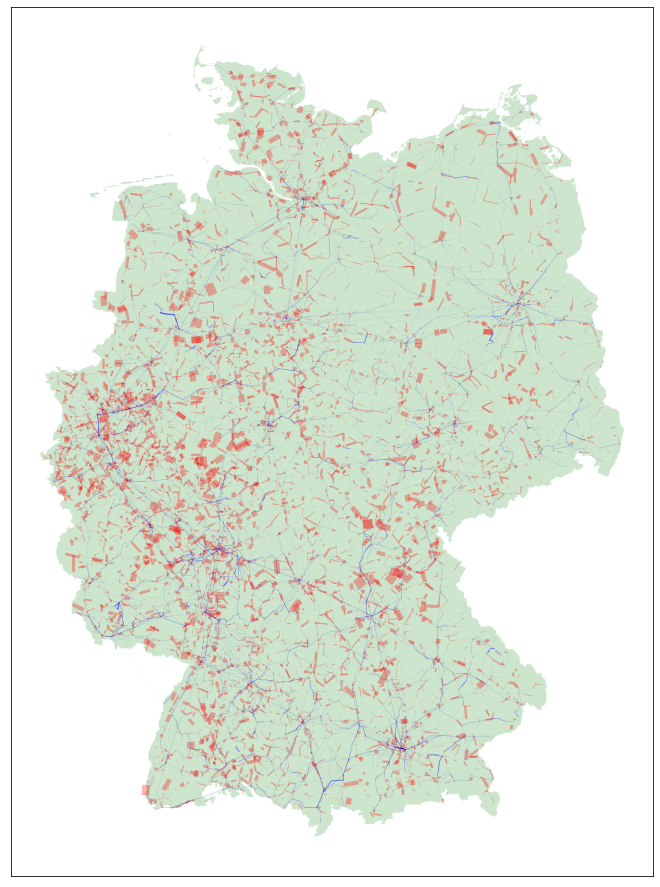

In [32]:
# Plot road and PT assignment
sm.links = gpd.GeoDataFrame(sm.links)
sm.road_links = gpd.GeoDataFrame(sm.road_links)
sm.zones = gpd.GeoDataFrame(sm.zones)
scaler = max(sm.links['volume'].max(), sm.road_links[('volume', 'car')].max()) / 35
sm.links.loc[sm.links['volume']>0, ['geometry']
            ].plot(alpha=.3, color='blue',
                   linewidth=list(sm.links.loc[sm.links['volume'].notna(), 'volume']/scaler),
    ax=sm.road_links.loc[sm.road_links[('volume', 'car')]>0, ['geometry']
                        ].plot(alpha=.3, color='red',
                               linewidth=list(sm.road_links.loc[sm.road_links[('volume', 'car')].notna()][('volume', 'car')]/scaler),
        ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))
plt.savefig(output_path + scenario + '/' + 'network_load_all.png', dpi=300)

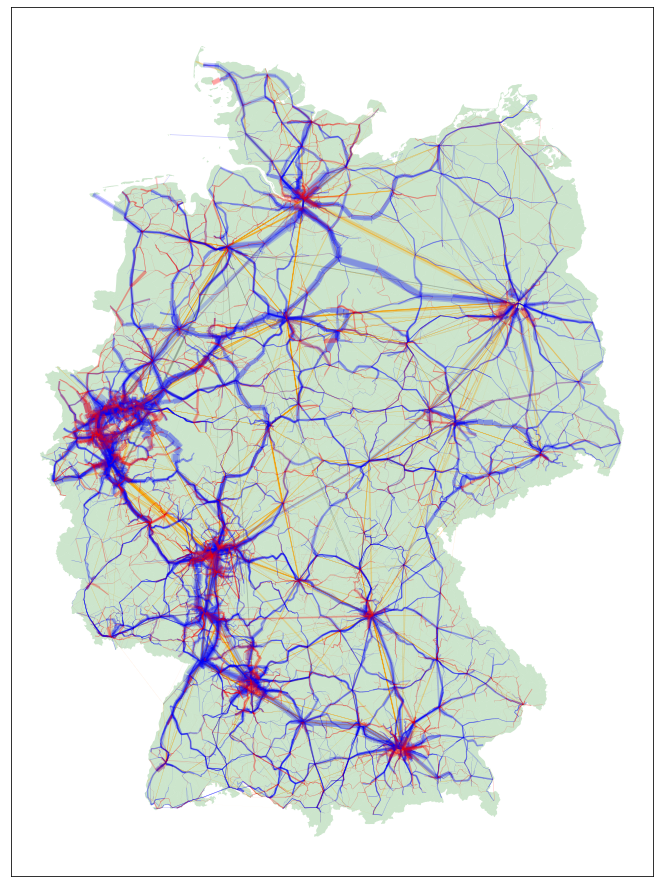

In [34]:
# Only PT
colors = sm.links['route_type'].map(
    {'rail': 'blue', 'rail_long': 'purple', 'rail_short': 'blue',
     'bus': 'red', 'subway': 'red', 'tram': 'red', 'ferry': 'red', 'funicular': 'red',
     'coach': 'orange', 'air': 'black', 'walk': 'grey'})
sm.links.loc[sm.links['volume']>0, ['geometry']].plot(
    alpha=.2,
    color=list(colors),
    linewidth=list(sm.links.loc[sm.links['volume']>0,'volume']
                   /sm.links.loc[sm.links['volume']>0,'volume'].max()*35),
    ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16)))
plt.savefig(output_path + scenario + '/' + 'network_load_pt.png', dpi=300)

### Validation

In [35]:
# Total difference between volumes and loads
vol = sm.volumes.set_index(['origin', 'destination']).sum(axis=1).rename('vol')
diff = sm.los.groupby(['origin', 'destination']).agg({'volume': 'sum'}).merge(
    vol, left_index=True, right_index=True)
diff['diff'] = diff['vol'] - diff['volume']

<AxesSubplot:>

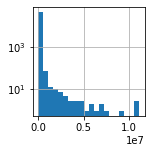

In [36]:
diff['diff'].hist(bins=20, log=True, figsize=(2,2))

In [43]:
diff['diff'].sum()

400835606.01203406

In [44]:
# Summary of LoS table volumes
#od_sum = sm.summary_od(costs=[])
od_sum = sm.los.rename(columns={'route_type':'mode'}).groupby(
    ['origin', 'destination', 'mode'])[sm.segments].sum()
for purpose in purposes:
    od_sum[purpose] = od_sum[[seg for seg in sm.segments if seg.split('_')[0]==purpose]].sum(axis=1)
od_sum.drop(sm.segments, axis=1, inplace=True)
od_sum['root'] = od_sum.sum(axis=1)
od_sum.columns = pd.MultiIndex.from_tuples([(c, 'volume') for c in od_sum.columns],
                                           names=['segment', 'sum'])

In [45]:
od_sum.sample()

,,segment,commuting,business,education,buy/execute,leisure,accompany,root
,,sum,volume,volume,volume,volume,volume,volume,volume
origin,destination,mode,,,,,,,
DE275_2,DE27D_3,walk,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# Add averages from following attributes
attrs = ['time', # hours per trip
         #'in_vehicle_time', # seconds per ride
         #'waiting_time', # seconds per ride
         'length', # Meter distance
         'ntransfers'] # per trip
means = sm.los.groupby(['origin', 'destination', 'route_type']).mean()[attrs]
for attr in attrs:
    od_sum[('root', attr)] = means[attr]

In [47]:
# Convert units
od_sum[('root', 'length')] /= 1000
#od_sum[('root', 'in_vehicle_time')] /= 3600
#od_sum[('root', 'waiting_time')] /= 3600

In [48]:
# Compute passenger kilometer
for seg in purposes + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[('root', 'length')]

In [49]:
# Load calibration dataset for modal split validation
mid_val = pd.read_csv(network_path + 'mid2017_validation_normalised.csv')
mid_val.set_index('mode_model', drop=True, inplace=True)
mode_dict_mid = {1: 'rail', 2: 'rail',
                 3: 'bus', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mid_val['mode_agg'] = [mode_dict_mid[i] for i in mid_val.index]

array([<AxesSubplot:ylabel='commuting'>, <AxesSubplot:ylabel='business'>,
       <AxesSubplot:ylabel='education'>,
       <AxesSubplot:ylabel='buy/execute'>, <AxesSubplot:ylabel='leisure'>,
       <AxesSubplot:ylabel='accompany'>], dtype=object)

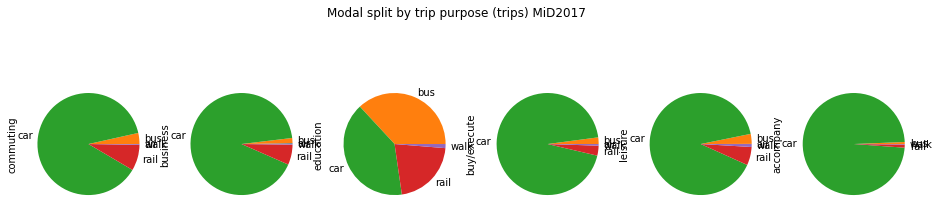

In [50]:
mid_val.groupby('mode_agg').sum()[purposes].plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose (trips) MiD2017')

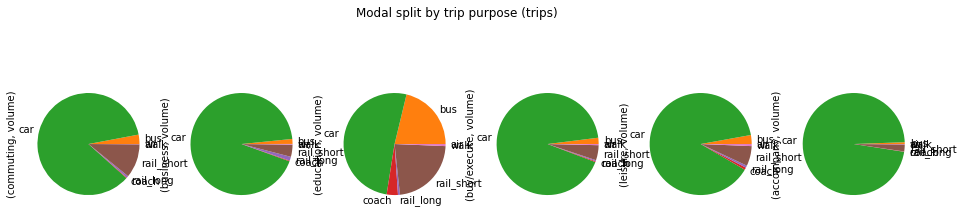

In [51]:
od_sum[[(seg, 'volume') for seg in purposes]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')
plt.savefig(output_path + scenario + '/' + 'modal_split_trips_segmented.png', dpi=300)

In [52]:
# MiD mode shares in percent
(mid_val.groupby('mode_agg').sum() /
 mid_val[purposes].sum() * 100)[purposes].round(2)

,commuting,business,education,buy/execute,leisure,accompany
mode_agg,,,,,,
air,0.00,0.26,0.00,0.01,0.05,0.00
bus,3.49,1.64,36.90,2.09,3.15,0.64
car,88.03,91.52,40.39,94.24,90.08,98.22
rail,8.22,6.38,21.42,3.14,5.79,0.98
walk,0.26,0.20,1.29,0.53,0.93,0.16


In [53]:
print('Model mode shares in percent')
print((od_sum[[(seg, 'volume') for seg in purposes]].groupby(level=2).sum() /
       od_sum[[(seg, 'volume') for seg in purposes]].sum() * 100).round(2))

segment,commuting,business,education,buy/execute,leisure,accompany
sum,volume,volume,volume,volume,volume,volume
mode,,,,,,
air,0.00,0.03,0.00,0.00,0.01,0.00
bus,2.97,1.57,21.23,1.98,2.82,0.57
car,85.40,92.89,51.28,92.26,88.76,96.99
coach,0.21,0.23,3.56,0.28,0.74,0.08
rail_long,0.57,1.24,0.63,0.34,0.70,0.03
rail_short,10.76,3.85,22.64,4.77,6.31,2.22
walk,0.09,0.19,0.65,0.37,0.65,0.12


In [54]:
# MiD2017 mode shares - total
mid_val['sum'] = mid_val[purposes].sum(axis=1)
(mid_val.groupby('mode_agg').agg({'sum': 'sum'}) / mid_val['sum'].sum() * 100).round(2)

,sum
mode_agg,
air,0.03
bus,4.12
car,89.24
rail,6.03
walk,0.57


In [55]:
print('Model mode shares in percent - total')
print((od_sum['root'].groupby(level=2).sum() / od_sum['root'].sum() * 100).round(2))

sum,volume,time,length,ntransfers,pkm
mode,,,,,
air,0.01,0.82,1.95,0.87,0.08
bus,3.34,20.18,9.10,39.34,1.57
car,87.73,16.21,30.29,0.00,89.08
coach,0.55,19.45,17.68,21.36,1.84
rail_long,0.60,8.44,13.26,8.03,1.29
rail_short,7.41,24.80,23.63,30.40,6.04
walk,0.36,10.10,4.09,0.00,0.11


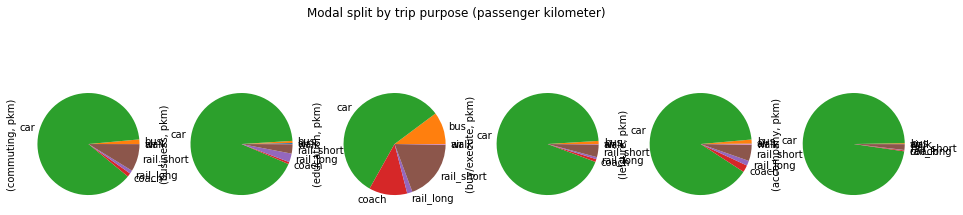

In [56]:
od_sum[[(seg, 'pkm') for seg in purposes]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose (passenger kilometer)')
plt.savefig(output_path + scenario + '/' + 'modal_split_pkm_segmented.png', dpi=300)

In [57]:
# Load VP2030 data for validation
vp2017 = pd.read_csv(network_path + 'vp2017_validation_normalised.csv')
# Restrict to inter-cell traffic and cells of the model
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017 = vp2017.groupby(['origin', 'destination']).sum()
mode_dict_vp = {'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'OESPV': 'bus', 'non': 'walk'}
vp2017.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[-1], mode_dict_vp[col.split('_')[0]]) for col in vp2017.columns],
    names=['segment', 'mode'])

In [58]:
# Normalise model volumes
od = od_sum[[(seg, 'volume') for seg in purposes]
           ].unstack('mode').fillna(0).droplevel('sum', axis=1)
od = (od-od.min())/(od.max()-od.min()).max()
# Scale model and validation data to the same level
od = od * (vp2017.mean().mean() / od.mean().mean())

In [59]:
# Define distance classes
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 300, 1000]
distances = sm.car_los.groupby(['origin', 'destination']).agg({'length': 'mean'}) / 1000
#island_dict = sm.zones.loc[['outer_1', 'outer_2'], 'NUTS_ID'].to_dict()
#sm.car_los['o'] = sm.car_los['origin'].replace(island_dict).str[:5]
#sm.car_los['d'] = sm.car_los['destination'].replace(island_dict).str[:5]
#distances_agg = sm.car_los.groupby(['o', 'd']).agg({'length': 'mean'}) / 1000
#distances_agg.index.set_names(['origin', 'destination'], inplace=True)
labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

In [60]:
# Cut matrices into distance classes
od['bins'] = pd.cut(od.merge(distances, how='left',
                             left_on=['origin', 'destination'],
                             right_index=True)['length'],
                    bins=bins, labels=labels)
vp2017['bins'] = pd.cut(vp2017.merge(distances, how='left',
                                     left_index=True,
                                     right_index=True)['length'],
                        bins=bins, labels=labels)

In [61]:
p_dict = dict(zip(vp_purpose_dict.values(), vp_purpose_dict.keys()))

In [68]:
if not 'rail' in od.columns.get_level_values(1):
    for p in purposes:
        od[(p, 'rail')] = od[(p, 'rail_short')] + od[(p, 'rail_long')]
        od[(p, 'bus')] = od[(p, 'bus')] + od[(p, 'coach')]

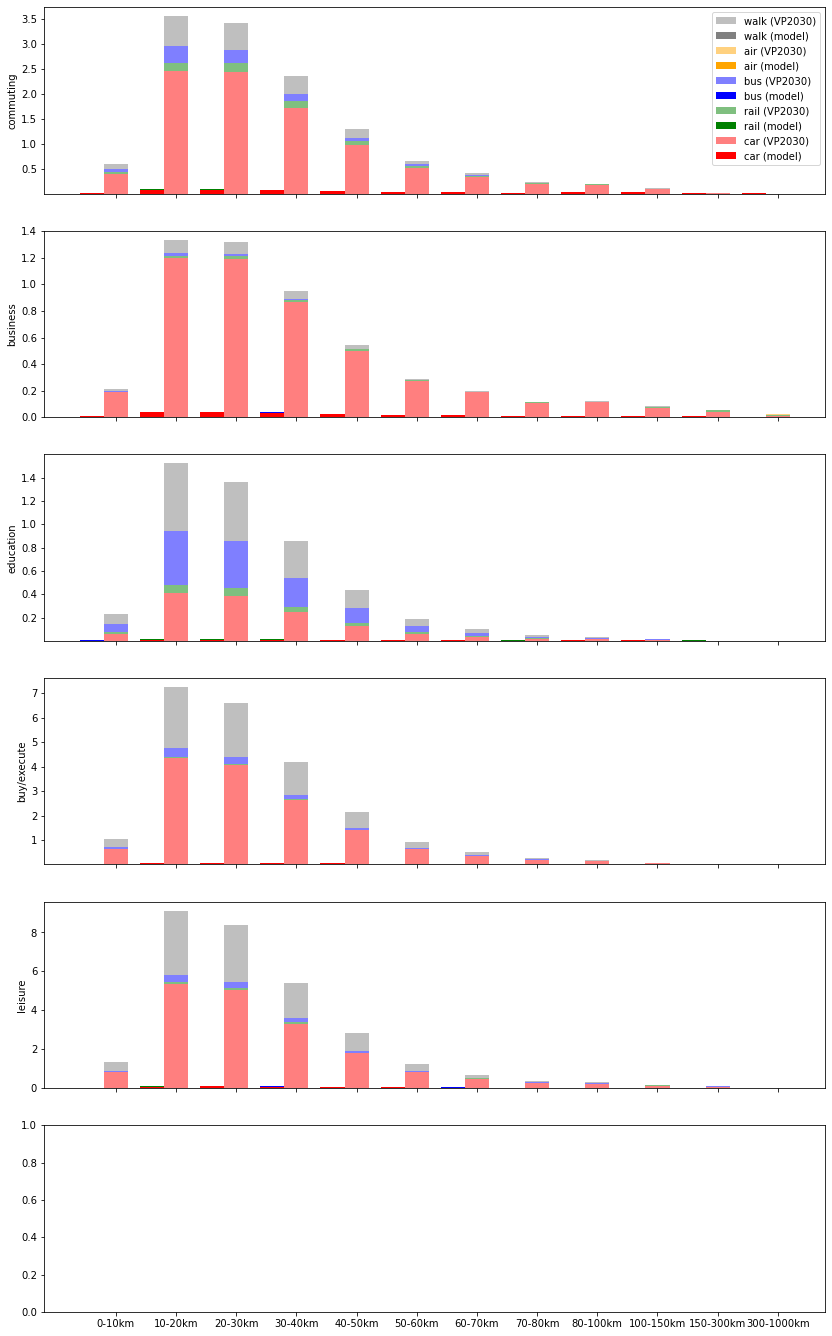

In [69]:
# Plot distance and mode distribution by segment
if manual:
    fig, ax = plt.subplots(nrows=len(purposes), ncols=1,
                           figsize=(14,len(purposes)*4),
                           sharex='all', sharey='row')
    width = 0.4
    ind = np.arange(len(labels))
    modes = ['car', 'rail', 'bus', 'air', 'walk']
    colors = ['red', 'green', 'blue', 'orange', 'grey']
    od_binned = od.groupby('bins').sum()
    vp_binned = vp2017.groupby('bins').sum()
    for seg in range(len(purposes[:-1])):
        model_vols = [od_binned[(purposes[seg], mode)] for mode in modes]
        vp_vols = [vp_binned[(p_dict[purposes[seg]], mode)] for mode in modes]
        for i in range(len(modes)):
            if i==0:
                model_bottom = 0
                vp_bottom = 0
            else:
                model_bottom = sum(model_vols[:i])
                vp_bottom = sum(vp_vols[:i])
            ax[seg].bar(ind, np.array(model_vols[i]), bottom=model_bottom,
                        width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
            ax[seg].bar(ind+width, np.array(vp_vols[i]), bottom=vp_bottom, alpha=.5,
                        width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
        ax[seg].set_ylabel(purposes[seg])
    h, l = ax[0].get_legend_handles_labels()
    ax[0].legend(h[::-1], l[::-1])
    plt.savefig(output_path + scenario + '/' + 'distance_validation_VP2030.png', dpi=300)

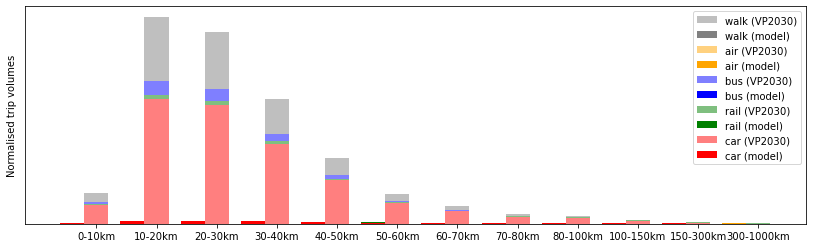

In [70]:
# Plot distance and mode distribution all together
if manual:
    fig, ax = plt.subplots(figsize=(14,4))
    model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
    vp_vols = vp_binned.stack().sum(axis=1).unstack()[modes].T.values
    for i in range(len(modes)):
        if i==0:
            model_bottom = 0
            vp_bottom = 0
        else:
            model_bottom = sum(model_vols[:i])
            vp_bottom = sum(vp_vols[:i])
        ax.bar(ind, model_vols[i], bottom=model_bottom,
               width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
        ax.bar(ind+width, vp_vols[i], bottom=vp_bottom, alpha=.5,
               width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
    ax.set_ylabel('Normalised trip volumes')
    ax.set_yticks([])
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[::-1], l[::-1])
    plt.savefig(output_path + scenario + '/' + 'distance_validation_VP2030_all.png', dpi=300)

In [71]:
# Load the calibration dataset for validation
mid2017 = pd.read_csv(input_path + 'transport_demand/calibration_inter-cellular_trips_MiD2017.csv')
# Replace LAU codes with NUTS IDs
assert str(mid2017.loc[0, 'origin']).startswith('DE')
# Rename modes and purposes
mid2017['mode_model'] = mid2017['mode_model'].map(mode_dict_mid)
mid2017['purpose_model'] = mid2017['purpose_model'].apply(lambda s: s.split('_')[0])

In [72]:
# Count observations by distance class
mid2017['length'] = mid2017.set_index(['origin', 'destination']
                                     ).index.map(distances.to_dict()['length'])
mid2017['bins'] = pd.cut(mid2017['length'], bins=bins, labels=labels)
mid2017 = mid2017.groupby(['bins', 'mode_model', 'purpose_model']).count()[
    ['origin']].unstack().unstack().fillna(0).droplevel(0, axis=1)

In [73]:
# Normalise and scale the dataset
mid2017 = (mid2017-mid2017.min())/(mid2017.max()-mid2017.min()).max()
mid2017 = mid2017 * (od_binned.mean().mean()
                     / mid2017.mean().mean())

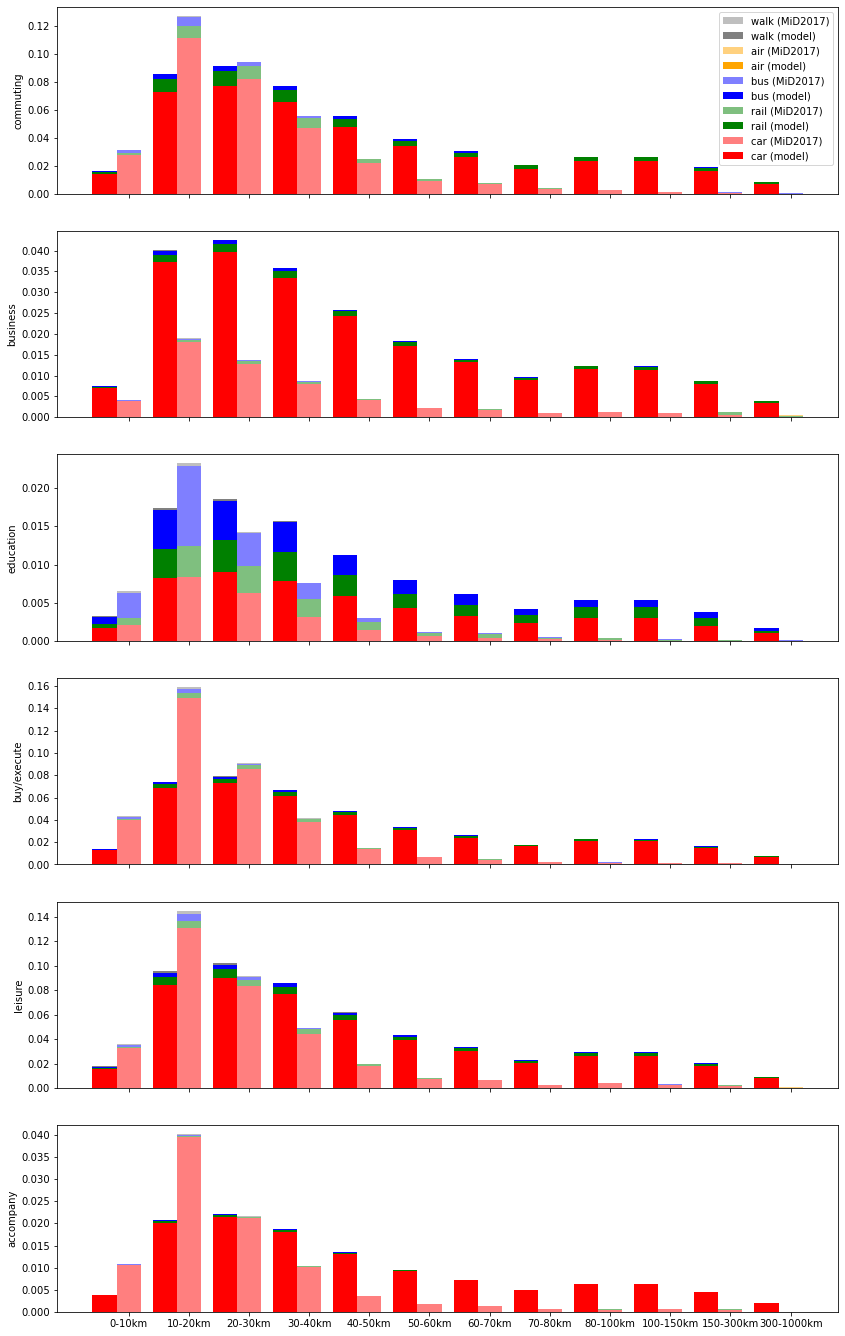

In [74]:
# Plot distance and mode distribution by segment
fig, ax = plt.subplots(nrows=len(purposes), ncols=1,
                       figsize=(14,len(purposes)*4),
                       sharex='all', sharey='row')
for seg in range(len(purposes)):
    model_vols = [od_binned[(purposes[seg], mode)] for mode in modes]
    mid_vols = [mid2017[(purposes[seg], mode)] for mode in modes]
    for i in range(len(modes)):
        if i==0:
            model_bottom = 0
            mid_bottom = 0
        else:
            model_bottom = sum(model_vols[:i])
            mid_bottom = sum(mid_vols[:i])
        ax[seg].bar(ind, np.array(model_vols[i]), bottom=model_bottom,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
        ax[seg].bar(ind+width, np.array(mid_vols[i]), bottom=mid_bottom, alpha=.5,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
    ax[seg].set_ylabel(purposes[seg])
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h[::-1], l[::-1])
plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017.png', dpi=300)

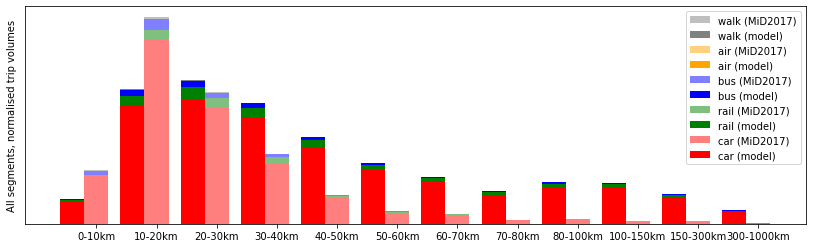

In [75]:
# Plot distance and mode distribution all together
fig, ax = plt.subplots(figsize=(14,4))
width = 0.4
model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
mid_vols = mid2017.stack().sum(axis=1).unstack()[modes].T.values
for i in range(len(modes)):
    if i==0:
        model_bottom = 0
        mid_bottom = 0
    else:
        model_bottom = sum(model_vols[:i])
        mid_bottom = sum(mid_vols[:i])
    ax.bar(ind, model_vols[i], bottom=model_bottom,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
    ax.bar(ind+width, mid_vols[i], bottom=mid_bottom, alpha=.5,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
ax.set_ylabel('All segments, normalised trip volumes')
ax.set_yticks([])
h, l = ax.get_legend_handles_labels()
ax.legend(h[::-1], l[::-1])
plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017_all.png', dpi=300)

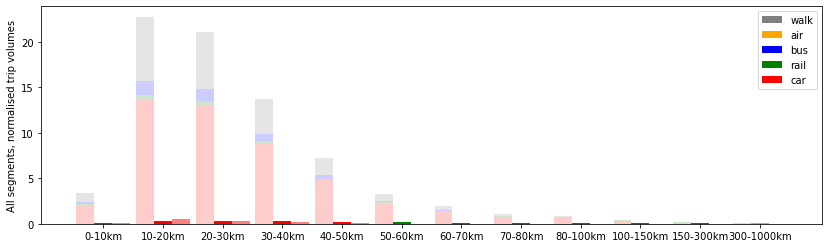

In [76]:
# Plot distance and mode distribution for all three data sources
if manual:
    fig, ax = plt.subplots(figsize=(14,4))
    width = 0.3
    vp_vols = vp_binned.stack().sum(axis=1).unstack()[modes].T.values
    model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
    mid_vols = mid2017.stack().sum(axis=1).unstack()[modes].T.values
    for i in range(len(modes)):
        if i==0:
            vp_bottom = 0
            model_bottom = 0
            mid_bottom = 0
        else:
            vp_bottom = sum(vp_vols[:i])
            model_bottom = sum(model_vols[:i])
            mid_bottom = sum(mid_vols[:i])
        ax.bar(ind-width, vp_vols[i], bottom=vp_bottom, alpha=.2,
               width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
        ax.bar(ind+width, mid_vols[i], bottom=mid_bottom, alpha=.5,
               width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
        ax.bar(ind, model_vols[i], bottom=model_bottom,
               width=width, tick_label=labels, color=colors[i], label=modes[i])#+' (model)')
    ax.set_ylabel('All segments, normalised trip volumes')
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[::-3], l[::-3])
    plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017_VP2030_all.png', dpi=300)

In [77]:
# Difference in the largest distance segment in % to MiD2017
(sum(model_vols.T[-1]) - sum(mid_vols.T[-1])) / sum(mid_vols.T[-1])

21.991607343482464

In [78]:
od_sum.xs('car', level=2)[('root', 'volume')].sum() / 1e6

16494.290466728824

In [79]:
# Sum up volumes of the model and VP2030
if manual:
    vol_df = pd.DataFrame(od[[c for c in od.columns
                              if c[0] in purposes and c[1]!='walk']
                            ].sum(axis=1).rename('quetzal_germany'))
    vol_df['VP2030'] = vp2017[[c for c in vp2017.columns
                               if c[0].startswith('Fz') and c[1]!='walk']
                             ].sum(axis=1)
    # Create distance classes
    dist_classes = list(range(0, 1011, 10))
    vol_df['distance [km]'] = pd.cut(vol_df.merge(distances, how='left',
                                                   left_index=True, right_index=True
                                                  )['length'],
                                     bins=dist_classes,
                                     labels=dist_classes[:-1])
    # Scaled normalised volumes: erronous, don't use them
    vol_df.groupby('distance [km]').agg({'quetzal_germany': 'sum', 'VP2030': 'sum'}
                                       ).plot(kind='area', stacked=False, alpha=.4,logx=True)

In [81]:
# Function to plot a traffic map
def plot_traffic(ax):
    pt_mask = (sm.links['volume'].notna()) & (sm.links['volume']>0)
    road_mask = (sm.road_links["('volume', 'car')"].notna()) & (sm.road_links["('volume', 'car')"]>0)
    scaler = max(sm.links['volume'].max(), sm.road_links["('volume', 'car')"].max()) / 50
    sm.links.loc[pt_mask, ['geometry']].plot(
        alpha=.5, color=blue, linewidth=list(sm.links.loc[pt_mask, 'volume']/scaler*2),
        ax=sm.road_links.loc[road_mask, ['geometry']].plot(
            alpha=.3, color='red',
            linewidth=list(sm.road_links.loc[road_mask, "('volume', 'car')"]/scaler),
            ax=sm.zones.plot(alpha=.2, color='green', ax=ax)))

In [83]:
# Figure for publication
if manual:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
    red = '#690709'
    blue = '#151770'
    grey = '#494949'
    yellow = '#887706'
    light = '#bdbdbd'
    red_ = '#6907098F'
    blue_ = '#1517708F'
    grey_ = '#4949498F'
    yellow_ = '#8877068F'
    light_ = '#bdbdbd8F'

    # double ring: Mode split model vs. MiD2017
    ax[0].axis('equal')
    width = 0.3
    model_values = od_sum[('root', 'volume')].groupby(level=2).sum().loc[
        ['car', 'rail', 'bus', 'walk']].rename(index={'walk': 'bicycle'})
    pie, _ = ax[0].pie(model_values, labels=model_values.index,
                       radius=1,
                       colors=[red, blue, yellow, grey])
    plt.setp( pie, width=width, edgecolor='white')
    ax[0].annotate(
        'quetzal_germany', xy=(-0.28, .82),
        bbox=dict(boxstyle="round", fc="white", lw=None, alpha=1)
    )
    mid_values = mid_val.groupby('mode_agg').sum()[purposes].sum(axis=1).loc[
        ['car', 'rail', 'bus', 'walk']]
    pie2, _ = ax[0].pie(mid_values,# labels=mid_values.index,
                        radius=1-width, labeldistance=0.7,
                        colors=[red_, blue_, yellow_, grey_])
    plt.setp( pie2, width=width, edgecolor='white')
    ax[0].annotate(
        'MiD2017', xy=(-0.155, .5),
        bbox=dict(boxstyle="round", fc="white", lw=None, alpha=1)
    )

    plot_traffic(ax[1])
    ax[1].axis('off')
    fig.tight_layout()
    plt.savefig(output_path + scenario + '/' + 'validation_mode_shares_traffic.png', dpi=400)

### Excel export

What do we need as outputs for energy and emission modelling? Most commonly, energy system models minimise total system cost under the constraint of emissions reduction towards a given goal. Costs include investments into vehicles (sometimes even infrastructure) and operating cost of these vehicles. Demand for transport is exogenously defined as activity rates per vehicle technology type in each time step. This model can contribute:
* passenger kilometer per mode and zone
* user cost, which can be translated into operating cost

In [84]:
# Keep only the aggregation of all purposes
od = od_sum.loc[:, 'root']

In [85]:
# Aggregated modal split in million pkm by main mode
od.groupby(level=2).sum()['pkm'] / 1e6

mode
air              804.873065
bus            16189.654249
car           920331.443207
coach          19052.104018
rail_long      13307.593754
rail_short     62406.448965
walk            1100.436659
Name: pkm, dtype: float64

In [86]:
# Aggregated pkm (million)
od.groupby(level=2).sum()['pkm'].sum() / 1e6

1033192.5539172698

In [87]:
# Total volumes between model zones (million)
sm.los['volume'].sum()/1e6

18801.539324866066

In [88]:
# Volumes between NUTS3-level (million)
sm.los.loc[sm.los['origin'].str[:5]!=sm.los['destination'].str[:5], 'volume'].sum() / 1e6

15706.213295238245

In [89]:
# Reduce table size by mapping origin and destination to bigger zones
od.reset_index(drop=False, inplace=True)
od['origin'] = od['origin'].str[:3] # NUTS1
od['destination'] = od['destination'].str[:3]

In [92]:
# Calculate weighted averages by zone aggregation
od['volume'] += 1e-6 # prevent weights being zero in sum
weighted_av = lambda x: np.average(x, weights=od.loc[x.index, 'volume'])
od = od.groupby(['origin', 'destination', 'mode']).agg(
    volumes=('volume', 'sum'),
    time=('time', weighted_av),
    #in_vehicle_time=('in_vehicle_time', weighted_av),
    length=('length', weighted_av)
)

## Save model

In [93]:
with pd.ExcelWriter(output_path + scenario + '/' + 'inter_zone.xlsx') as writer:
    od.to_excel(writer, sheet_name='od')

In [94]:
sm.to_zippedpickles(model_path + 'de_assignment',
                    only_attributes=['links', 'nodes', 'road_links', 'volumes'])

los: 100%|█████████████████████████████████████████████████████████████████████████████| 38/38 [00:10<00:00,  3.78it/s]


In [ ]:
# Save distances between centroids in km
if manual:
    (car.car_los.groupby(['origin', 'destination']).agg({'length': 'mean'}) / 1000
    ).astype(int).to_csv(output_path + 'distances_centroids.csv')